In [11]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()

# Importing data

### Selecting Language

In [2]:
language = 'tam'
start_token = '<'
end_token = '>'
pad_token = ' '

In [3]:
path = 'aksharantar_sampled/' + language

train_df = pd.read_csv(path+'/'+language+'_train.csv', header=None)
test_df = pd.read_csv(path+'/'+language+'_test.csv', header=None)
val_df = pd.read_csv(path+'/'+language+'_valid.csv', header=None)

train_source, train_target = train_df[0].tolist(), train_df[1].tolist()
test_source, test_target = test_df[0].tolist(), test_df[1].tolist()
val_source, val_target = val_df[0].tolist(), val_df[1].tolist()

### Printing Sample

In [4]:
num_sample = 5
for i in range(num_sample):
    print(f'{train_source[i]}  -->  {train_target[i]}')

thottacharya  -->  தொட்டாச்சார்ய
menmaithaan  -->  மென்மைதான்
avarantri  -->  அவரன்றி
mudiyarathu  -->  முடியறது
aadaiyanigalaal  -->  ஆடையணிகளால்


In [5]:
english_chars = list(set(''.join(train_source) + start_token + end_token + pad_token))
target_chars = list(set(''.join(train_target) + start_token + end_token + pad_token))

english_dict_count = len(english_chars)
target_dict_count = len(target_chars)

print("Number of Charecters : ", target_dict_count)

print("Target Charecters: ")
for i, c in enumerate(target_chars):
    print(i, c, end='\t')
    if i % 5 == 0:
        print()

Number of Charecters :  49
Target Charecters: 
0 இ	
1 ஸ	2 வ	3 ீ	4 ண	5 ங	
6 ம	7 ஹ	8 உ	9 ஜ	10 ே	
11 ூ	12 ஓ	13 ட	14 ப	15 ந	
16 ா	17 ழ	18 ு	19 ெ	20 ஈ	
21 ர	22 அ	23 ள	24 ்	25 ஒ	
26 ொ	27 ஷ	28 ன	29 >	30 ஏ	
31 ஃ	32 ல	33 ை	34  	35 த	
36 ச	37 ற	38 க	39 ோ	40 ஞ	
41 எ	42 ஊ	43 ௌ	44 ஐ	45 ஆ	
46 <	47 ய	48 ி	

In [6]:
en_i2l, en_l2i = {}, {}
tr_i2l, tr_l2i = {}, {}

for i, x in enumerate(english_chars):
    en_l2i[x] = i
    en_i2l[i] = x

for i, x in enumerate(target_chars):
    tr_l2i[x] = i
    tr_i2l[i] = x

# Utility Functions

In [12]:
def data_loader(source, target, batch_size):
    """
    returns: list of list which contains padded (source, target) pairs
    """
    res = []
    for i in range(0, len(source), batch_size):
        batch = []
        src_batch = source[i:i+batch_size]
        tar_batch = target[i:i+batch_size]
        scr_max_len = len(max(src_batch, key=len))
        tar_max_len = len(max(tar_batch, key=len))

        for j in range(len(src_batch)):
            padded_scr, padded_tar = src_batch[j].ljust(scr_max_len), tar_batch[j].ljust(tar_max_len)
            batch.append((padded_scr, padded_tar))

        res.append(batch)
    
    return res


In [13]:
def preprocess(strings):
    """Adds start and end token and adds padding"""
    res = []
    max_len = len(max(strings, key=len))

    for item in strings:
        temp = start_token + item + end_token
        temp = temp.ljust(max_len+2, pad_token) #2 is added, because we added start and end token to each word
        res.append(temp)

    return res

In [14]:
def string_to_tensor(strings, l2i_dict):
    """
    replaces the chareceters of the sting with corrospong ix (by refering l2i_dict) and returns as int tensor
    """
    res = torch.zeros(len(strings), len(strings[0]))
    
    for i in range(len(strings)):
        for j in range(len(strings[i])):
            if strings[i][j] not in l2i_dict :
                continue #ignoring the charecters that are not in the dictionary
            res[i][j] = l2i_dict[strings[i][j]]
        
    return res.type(torch.LongTensor)

In [15]:
def calc_loss(model, soruce_strings, target_strings, batch_size = 32):
    running_loss  = 0
    for i in range(0, len(soruce_strings), batch_size):
        inp_data = string_to_tensor(preprocess(soruce_strings[i:i+batch_size]), en_l2i).transpose(0,1)
        target = string_to_tensor(preprocess(target_strings[i:i+batch_size]), tr_l2i).transpose(0,1)

        output = model(inp_data, target)
        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)

        loss = criterion(output, target)
        running_loss += loss.item()

    return running_loss


### Preprocessing test and validation data

In [16]:
val_source_tensor = string_to_tensor(preprocess(val_source), en_l2i).transpose(0,1)
val_target_tensor = string_to_tensor(preprocess(val_target), tr_l2i).transpose(0,1)

test_source_tensor = string_to_tensor(preprocess(test_source), en_l2i).transpose(0,1)
test_target_tensor = string_to_tensor(preprocess(test_target), tr_l2i).transpose(0,1)

# Encoder

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers = 1, p = 0, bi_dir = False):
        """
        Init Parameters:
        input_size : english_dict_count
        embedding_size : size of each embedding vector
        hidden_size : size of hidden state vector
        num_layers : number of recurrent layers of RNN
        p : dropout probability

        Input:
        x : torch.Tensor of shape (seq_length, N)
            where seq_length - len of longest string in the batch
            N - batch size
        
        Outpus:
        outputs: torch.Tensor of shape (seq_len, N, hidden_size * D), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size)
        """
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)


    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        outputs, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)
        

        return outputs, hidden, cell

# Decoder

In [50]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers = 1, p = 0, bi_dir = False):
        """input size = output size = target language charecters
        Init Parameters:
        input_size: target_dict_count
        embedding_size: size of each embedding vector
        hidden_size: size of hidden state vector
        output_size: number of output features in fully connected layer
        num_layers : number of recurrent layers of RNN
        p : dropout probability

        Input:
        x: torch.Tensor of shape (N)
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size)

        Outputs:
        predications: torch.Tensor of shape (N, target_dict_count), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size)
        """
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)
        D = 1
        if(bi_dir == True):
            D = 2
        self.fc = nn.Linear(hidden_size * D, output_size)


    def forward(self, x, hidden, cell):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        print(x.shape, hidden.shape, cell.shape)
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)
        
        outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputs shape: (1, N, hidden_size * D)

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        return predictions, hidden, cell

# Model

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        """source : (source_len, N) - not sure
        """
        batch_size = source.shape[1] 
        target_len = target.shape[0]
        target_vocab_size = target_dict_count

        # print("source shape ", source.shape)
        # print("target shape ", target.shape)
        # print("N : ", batch_size)
        # print("tar len : ", target_len)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size)
        # print("outputs shape : ", outputs.shape)

        _, hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]
        outputs[:, :, tr_l2i[start_token]] = 1 #setting prob = 1 for starting token 

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, cell = self.decoder(x, hidden, cell)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        # print("OUTPUTS: ", outputs)
        return outputs

# Training

In [53]:
# Training hyperparameters
num_epochs = 50
learning_rate = 0.001
batch_size = 2

# Model hyperparameters
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = english_dict_count
input_size_decoder = target_dict_count
output_size = target_dict_count
encoder_embedding_size = 10
decoder_embedding_size = 10
hidden_size = 512  # Needs to be the same for both RNN's
encoder_layers = 1
decoder_layers = 1
enc_dropout = 0
dec_dropout = 0
embedding_size= 16
hidden_size = 10
bi_directional = True

In [54]:
enc = Encoder(english_dict_count, embedding_size, hidden_size, num_layers=encoder_layers, bi_dir=bi_directional)
dec = Decoder(target_dict_count, embedding_size, hidden_size, target_dict_count, num_layers=decoder_layers, bi_dir=bi_directional)

mod = Seq2Seq(enc, dec)

optimizer = optim.Adam(mod.parameters(), lr=learning_rate)

## func

In [55]:
def temp_print(output):
    """output shape: target_seq_length * N"""
    res = []
    for j in range(output.shape[1]):
        temp = ""
        for i in range(output.shape[0]):
            temp += tr_i2l[output[i,j].item()]
        
        res.append(temp)
    return res

torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.Size([2]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
IN DECODER
torch.Size([1, 2, 20]) torch.Size([2, 2, 10]) torch.Size([2, 2, 10])
torch.

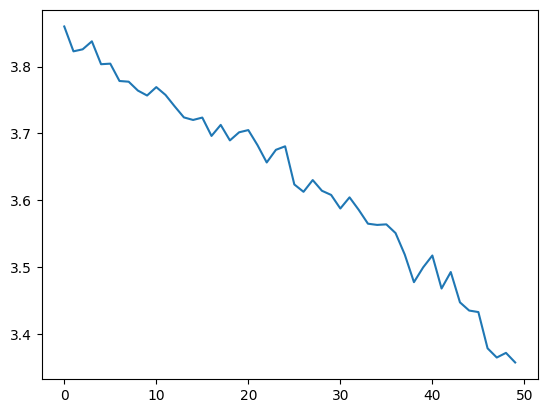

In [56]:
loss_list = []
for epoch in range(num_epochs):
    running_loss = 0
    no_of_batch = 0
    for i in range(0, len(train_source[:2]), batch_size):
        src_strings = train_source[i: i+batch_size]
        tar_strings = train_target[i: i+batch_size]

        src_strings = preprocess(src_strings)
        tar_strings = preprocess(tar_strings)

        #transposing to make the shape as expected
        inp_data = string_to_tensor(src_strings, en_l2i).transpose(0,1)
        target = string_to_tensor(tar_strings, tr_l2i).transpose(0,1)


        output = mod(inp_data, target)
        result = temp_print(output.argmax(2))
        # print("result: ", result)
        # print("target: ", tar_strings)
        
        print("output: ",result)
        print("target:", tar_strings)

        # print("op before reshopsed ", output.shape)
        # print("tar before reshape: ", target.shape)

        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)

        # print("op: ", output.shape)
        # print("tar: ", target.shape)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mod.parameters(), max_norm=1)
        optimizer.step()
        running_loss += loss.item()
        no_of_batch += 1

    # val_output = mod(val_source_tensor, val_target_tensor)
    # val_output = val_output.reshape(-1, val_output.shape[2])
    # val_target_tensor = val_target_tensor.reshape(-1)
    # # print(f"val output : {val_output.shape} \t val_target: {val_target_tensor.shape}")
    # val_loss = criterion(val_output, val_target_tensor)

    val_loss= calc_loss(mod, val_source[:2], val_target[:2])
    # val_loss = 0

    print(f"[Epoch {epoch+1:3d} / {num_epochs}] \t Loss: {(running_loss/no_of_batch):.4f} \t Val Loss: {val_loss:2.4f}")
    print()
    loss_list.append(running_loss/no_of_batch)

plt.plot(loss_list)